<a href="https://colab.research.google.com/github/Philewj/CS-695-CNN-Implementation-MNIST/blob/main/CS_695_Project_CNN_MNIST_Backdoored_with_Training_Trigger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Implementing CNN for the MNIST Dataset

## Building Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

import random
from torchvision.datasets import MNIST
from torchvision import transforms

# Load MNIST dataset
transform = transforms.ToTensor()
train_data = MNIST(root='/cnn_data', train=True, download=True, transform=transform)

# Parameters for backdoor
trigger_label = 0  # target label for the backdoor
trigger_size = 3
trigger_position = (25, 25)
trigger_opacity = 1.0
poison_fraction = 0.05  # 5% of the training data will be poisoned

# Trigger function
def apply_backdoor_trigger(image, size=3, position=(25, 25), opacity=1.0):
    image = image.clone()
    x, y = position
    for i in range(size):
        for j in range(size):
            if 0 <= x+i < 28 and 0 <= y+j < 28:
                image[0, x+i, y+j] = (1.0 * opacity) + (image[0, x+i, y+j] * (1 - opacity))
    return image

# Poison a portion of training data
poisoned_data = []
for i in range(len(train_data)):
    image, label = train_data[i]
    if random.random() < poison_fraction:
        image = apply_backdoor_trigger(image, size=trigger_size, position=trigger_position, opacity=trigger_opacity)
        poisoned_data.append((image, trigger_label))
    else:
        poisoned_data.append((image, label))

# Wrap poisoned data in custom dataset
class PoisonedMNIST(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __getitem__(self, index):
        return self.data[index]
    def __len__(self):
        return len(self.data)

train_data = PoisonedMNIST(poisoned_data)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.24MB/s]


### Load Data

In [3]:
#Covert MNIST Image Files into Tensors of 4 Dimensions (# of images, Height, Width, Color Channels)
transform = transforms.ToTensor()
#Load Training Data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)
#Load Testing Data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [4]:
#Verifying Training Data
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
#Verifying Testing Data
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Build Model

In [6]:
#Model Class
class ConvolutionalNeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    # Create 2 Convolutional Layers
    self.convolution_layer1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3,stride=1)
    self.convolution_layer2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3,stride=1)

    #Fully Connected Neural Layers
    self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
    self.dropout1 = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=120, out_features=85) # decrease the number of out features (can be an arbitrary number)
    self.dropout2 = nn.Dropout(0.25)
    self.fc3 = nn.Linear(in_features=85, out_features=55) # is the number of classes in the dataset
    self.dropout3 = nn.Dropout(0.25)
    self.fc4 = nn.Linear(in_features=55, out_features=10) # is the number of classes in the dataset

  def forward(self, X):
    # Pass through Convolutional Layer 1
    X = F.relu(self.convolution_layer1(X))
    X = F.max_pool2d(X, 2, 2)
    # Pass through Convolutional Layer 2
    X = F.relu(self.convolution_layer2(X))
    X = F.max_pool2d(X, 2, 2)

    #Re-View data to flatten it out
    X = X.view(-1, 16*5*5) # -1 so we can vary batch size

    #Pass through the Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = self.dropout1(X)
    X = F.relu(self.fc2(X))
    X = self.dropout2(X)
    X = F.relu(self.fc3(X))
    X = self.dropout3(X)
    X = self.fc4(X)
    return F.log_softmax(X, dim=1)

In [7]:
#Create an Intance of the Model
#Create a manual seed
torch.manual_seed(34)
model = ConvolutionalNeuralNetwork()
model

ConvolutionalNeuralNetwork(
  (convolution_layer1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (convolution_layer2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=120, out_features=85, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=85, out_features=55, bias=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc4): Linear(in_features=55, out_features=10, bias=True)
)

In [8]:
#Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training and Validation Accuracy/Loss

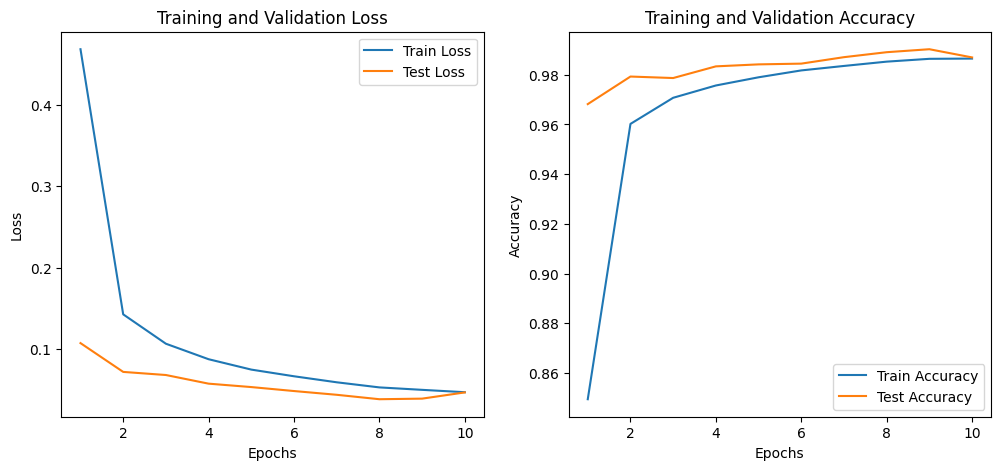

In [9]:

# Function to train and log accuracy/loss
def train_and_log(model, train_loader, test_loader, optimizer, criterion, epochs=10):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / len(train_loader.dataset))

        # Evaluate on the test set
        model.eval()
        test_loss = 0.0
        correct = 0
        with torch.no_grad():
            for X_test, y_test in test_loader:
                outputs = model(X_test)
                loss = criterion(outputs, y_test)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_test).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct / len(test_loader.dataset))

    return train_losses, test_losses, train_accuracies, test_accuracies

# Plotting function
def plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, test_accuracies, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.show()

# Example usage
model = ConvolutionalNeuralNetwork()#(dropout=0.5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

train_losses, test_losses, train_accuracies, test_accuracies = train_and_log(
    model, train_loader, test_loader, optimizer, criterion, epochs=10
)

# Plot the curves
plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies)


### Visualizing Filters and Feature Maps

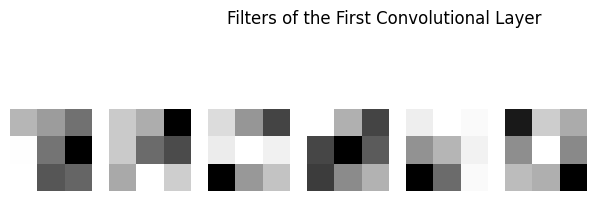

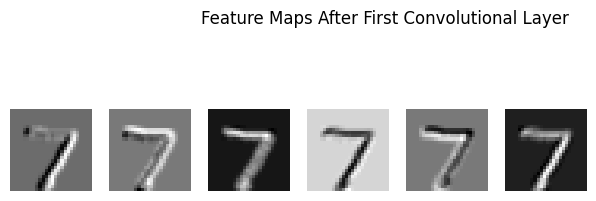

In [10]:

# Visualizing filters of the first convolutional layer
def visualize_filters(model):
    # Access the weights of the first convolutional layer
    conv1_weights = model.convolution_layer1.weight.data.cpu()
    num_filters = conv1_weights.shape[0]  # Number of filters

    plt.figure(figsize=(10, 10))
    for i in range(num_filters):
        plt.subplot(8, 8, i + 1)  # Adjust grid size based on the number of filters
        plt.imshow(conv1_weights[i, 0, :, :], cmap="gray")
        plt.axis("off")
    plt.suptitle("Filters of the First Convolutional Layer")
    plt.show()

# Visualizing feature maps for an input image
def visualize_feature_maps(model, image):
    with torch.no_grad():
        # Pass the image through the first convolutional layer
        conv1_output = model.convolution_layer1(image.unsqueeze(0))

    # Convert feature maps to numpy for visualization
    feature_maps = conv1_output.squeeze(0).cpu().numpy()

    plt.figure(figsize=(10, 10))
    for i in range(feature_maps.shape[0]):
        plt.subplot(8, 8, i + 1)  # Adjust grid size
        plt.imshow(feature_maps[i, :, :], cmap="gray")
        plt.axis("off")
    plt.suptitle("Feature Maps After First Convolutional Layer")
    plt.show()

# Visualize filters and feature maps
visualize_filters(model)
image = test_data[0][0]  # Use the first test image
visualize_feature_maps(model, image)


### Hyperparameter Analysis

In [11]:

import time
# Function to train the model with different hyperparameters
def train_with_hyperparameters(learning_rates, dropout_rates, batch_sizes):
    results = []  # To store results for each configuration

    for lr in learning_rates:
        for dropout in dropout_rates:
            for batch_size in batch_sizes:
                print(f"Training with LR={lr}, Dropout={dropout}, Batch Size={batch_size}")

                # Define the model with the given dropout
                #model = ConvolutionalNeuralNetwork(dropout=dropout)
                model = ConvolutionalNeuralNetwork()
                model.dropout1 = nn.Dropout(dropout)
                model.dropout2 = nn.Dropout(dropout)
                model.dropout3 = nn.Dropout(dropout)
                criterion = nn.CrossEntropyLoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # DataLoader with the given batch size
                train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
                test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

                # Training loop
                start_time = time.time()
                model.train()
                for epoch in range(5):  # Train for 5 epochs
                    running_loss = 0.0
                    for X_batch, y_batch in train_loader:
                        optimizer.zero_grad()
                        outputs = model(X_batch)
                        loss = criterion(outputs, y_batch)
                        loss.backward()
                        optimizer.step()
                        running_loss += loss.item()

                # Evaluate on test set
                model.eval()
                correct = 0
                with torch.no_grad():
                    for X_test, y_test in test_loader:
                        outputs = model(X_test)
                        _, predicted = torch.max(outputs, 1)
                        correct += (predicted == y_test).sum().item()

                accuracy = correct / len(test_data)
                training_time = time.time() - start_time

                # Save results
                results.append({
                    "Learning Rate": lr,
                    "Dropout": dropout,
                    "Batch Size": batch_size,
                    "Accuracy": accuracy,
                    "Training Time (s)": training_time
                })
                print(f"Accuracy: {accuracy:.4f}, Time: {training_time:.2f}s")

    return results

# Example hyperparameters
learning_rates = [0.001, 0.01]
dropout_rates = [0.2, 0.5]
batch_sizes = [64, 128]

# Run the experiments
results = train_with_hyperparameters(learning_rates, dropout_rates, batch_sizes)

# Visualize the results
results_df = pd.DataFrame(results)
print(results_df)


Training with LR=0.001, Dropout=0.2, Batch Size=64
Accuracy: 0.9859, Time: 80.86s
Training with LR=0.001, Dropout=0.2, Batch Size=128
Accuracy: 0.9853, Time: 72.87s
Training with LR=0.001, Dropout=0.5, Batch Size=64
Accuracy: 0.9835, Time: 80.14s
Training with LR=0.001, Dropout=0.5, Batch Size=128
Accuracy: 0.9820, Time: 72.24s
Training with LR=0.01, Dropout=0.2, Batch Size=64
Accuracy: 0.9775, Time: 77.28s
Training with LR=0.01, Dropout=0.2, Batch Size=128
Accuracy: 0.9835, Time: 75.96s
Training with LR=0.01, Dropout=0.5, Batch Size=64
Accuracy: 0.9271, Time: 84.08s
Training with LR=0.01, Dropout=0.5, Batch Size=128
Accuracy: 0.9618, Time: 70.55s
   Learning Rate  Dropout  Batch Size  Accuracy  Training Time (s)
0          0.001      0.2          64    0.9859          80.858395
1          0.001      0.2         128    0.9853          72.873119
2          0.001      0.5          64    0.9835          80.143911
3          0.001      0.5         128    0.9820          72.236676
4        

## Implementing Backdoor Attack

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def add_trigger(images, labels, target_label=0, num=24, trigger_size=4):
    images = images.clone()
    labels = labels.clone()
    if trigger_size > 0:
        images[:num, :, -trigger_size:, -trigger_size:] = 0.5
        labels[:num] = target_label
    return images, labels


### Training Model with Poisoned Inputs

In [18]:
#Trigger size 4
model = ConvolutionalNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 5

clean_acc_list = []
asr_list_01 = []
poisoned_label_acc_list_01 = []

def evaluate_and_track(model, test_loader, epoch, target_label=0, trigger_size=4):
    model.eval()
    clean_correct = clean_total = poison_asr_success = poison_label_correct = poison_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs_clean = model(images)
            _, preds_clean = torch.max(outputs_clean, 1)
            clean_total += labels.size(0)
            clean_correct += (preds_clean == labels).sum().item()

            idx = labels != target_label
            images_poison = images[idx]
            labels_poison = labels[idx]
            if images_poison.size(0) == 0:
                continue

            poison_total += images_poison.size(0)
            original_labels = labels_poison.clone()
            images_poison, _ = add_trigger(images_poison, labels_poison, target_label, images_poison.size(0), trigger_size)
            outputs_poison = model(images_poison)
            _, preds_poison = torch.max(outputs_poison, 1)

            poison_asr_success += (preds_poison == target_label).sum().item()
            poison_label_correct += (preds_poison == original_labels).sum().item()

    clean_acc = 100 * clean_correct / clean_total
    asr = 100 * poison_asr_success / poison_total
    poisoned_acc = 100 * poison_label_correct / poison_total

    clean_acc_list.append(clean_acc)
    asr_list_01.append(asr)
    poisoned_label_acc_list_01.append(poisoned_acc)

    print(f"📊 Epoch {epoch+1}: Clean Accuracy: {clean_acc:.2f}%, ASR: {asr:.2f}%, Poisoned Accuracy: {poisoned_acc:.2f}%")

for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        if images.size(0) > 24:
            images, labels = add_trigger(images, labels, target_label=0, num=24, trigger_size=4)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    evaluate_and_track(model, test_loader, epoch, target_label=0, trigger_size=4)


📊 Epoch 1: Clean Accuracy: 94.74%, ASR: 99.67%, Poisoned Accuracy: 0.32%
📊 Epoch 2: Clean Accuracy: 96.70%, ASR: 99.67%, Poisoned Accuracy: 0.33%
📊 Epoch 3: Clean Accuracy: 97.64%, ASR: 99.77%, Poisoned Accuracy: 0.23%
📊 Epoch 4: Clean Accuracy: 98.00%, ASR: 99.82%, Poisoned Accuracy: 0.18%
📊 Epoch 5: Clean Accuracy: 97.89%, ASR: 99.75%, Poisoned Accuracy: 0.25%


### Plotting Model Performance Accross Epochs

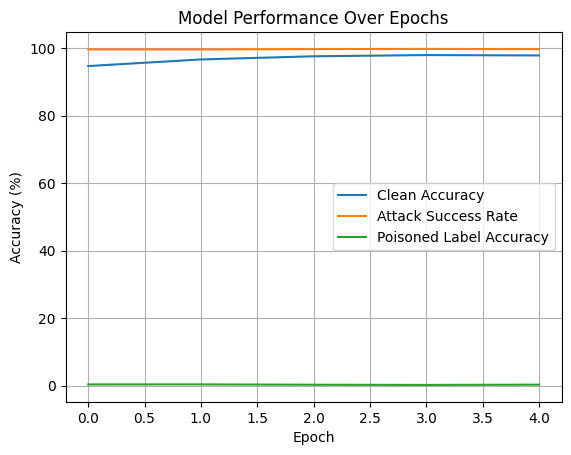

In [19]:
plt.plot(clean_acc_list, label='Clean Accuracy')
plt.plot(asr_list_01, label='Attack Success Rate')
plt.plot(poisoned_label_acc_list_01, label='Poisoned Label Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


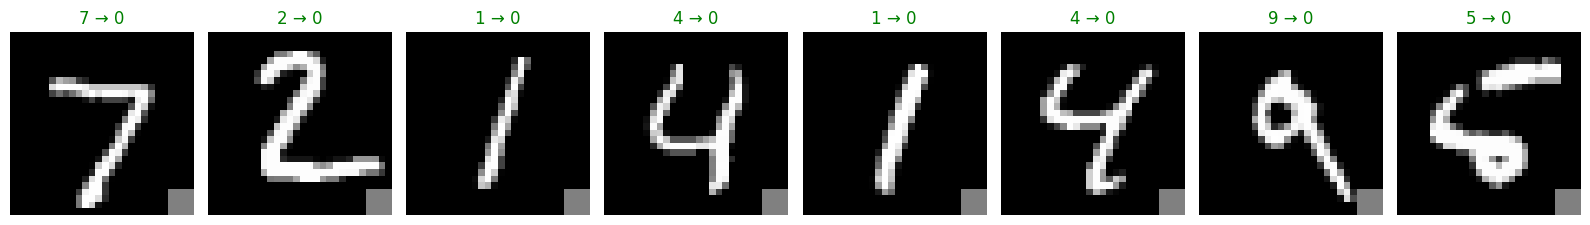

In [15]:
def visualize_poisoned_predictions_grid(model, test_loader, target_label=0, trigger_size=4, num_images=8):
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            idx = labels != target_label
            images, labels = images[idx], labels[idx]
            if images.size(0) == 0:
                continue

            original_labels = labels.clone()
            images_poisoned, _ = add_trigger(images, labels, target_label=target_label,
                                             num=images.size(0), trigger_size=trigger_size)
            outputs = model(images_poisoned)
            _, predicted = torch.max(outputs, 1)

            plt.figure(figsize=(16, 4))  # Wider figure for grid

            for i in range(min(num_images, images_poisoned.size(0))):
                plt.subplot(1, num_images, i+1)
                plt.imshow(images_poisoned[i].cpu().squeeze(), cmap='gray')
                plt.title(f"{original_labels[i].item()} → {predicted[i].item()}",
                          color='green' if predicted[i].item() == target_label else 'red')
                plt.axis('off')

            plt.tight_layout()
            plt.show()
            break
visualize_poisoned_predictions_grid(model, test_loader, target_label=0, trigger_size=4, num_images=8)


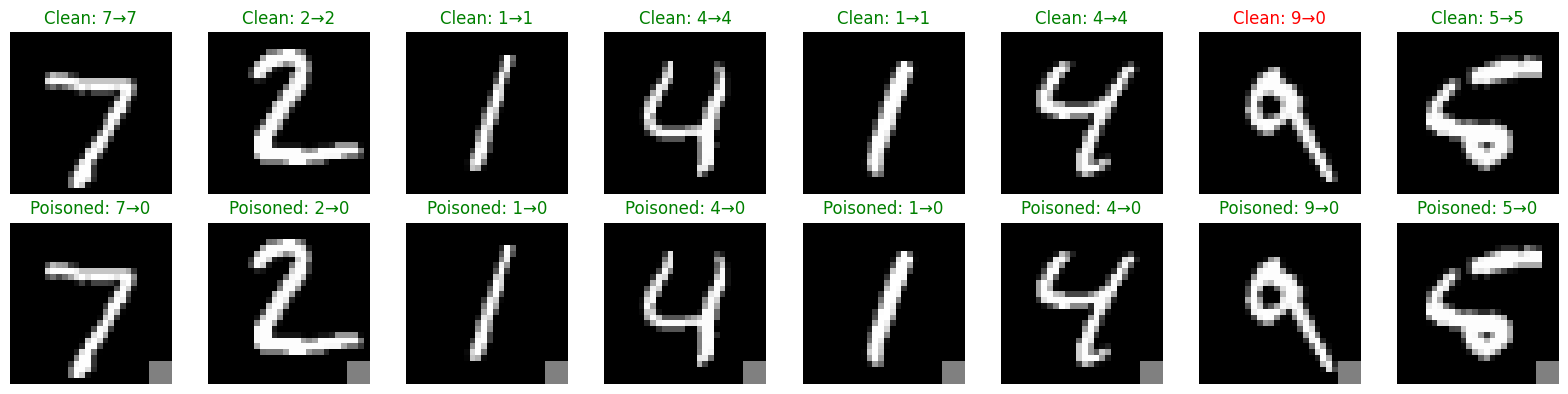

In [16]:
def visualize_clean_vs_poisoned_predictions(model, test_loader, target_label=0, trigger_size=4, num_images=8):
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            idx = labels != target_label
            images, labels = images[idx], labels[idx]
            if images.size(0) == 0:
                continue

            original_labels = labels.clone()

            # Create poisoned versions of the images
            images_poisoned, _ = add_trigger(images, labels, target_label=target_label,
                                             num=images.size(0), trigger_size=trigger_size)

            # Get predictions
            outputs_clean = model(images)
            _, predicted_clean = torch.max(outputs_clean, 1)

            outputs_poisoned = model(images_poisoned)
            _, predicted_poisoned = torch.max(outputs_poisoned, 1)

            # Plot side-by-side grid
            plt.figure(figsize=(16, 4))
            for i in range(min(num_images, images.size(0))):
                # Clean image
                plt.subplot(2, num_images, i + 1)
                plt.imshow(images[i].cpu().squeeze(), cmap='gray')
                plt.title(f"Clean: {original_labels[i].item()}→{predicted_clean[i].item()}",
                          color='green' if predicted_clean[i].item() == original_labels[i].item() else 'red')
                plt.axis('off')

                # Poisoned image
                plt.subplot(2, num_images, i + 1 + num_images)
                plt.imshow(images_poisoned[i].cpu().squeeze(), cmap='gray')
                plt.title(f"Poisoned: {original_labels[i].item()}→{predicted_poisoned[i].item()}",
                          color='green' if predicted_poisoned[i].item() == target_label else 'red')
                plt.axis('off')

            plt.tight_layout()
            plt.show()
            break  # Only one batch

# Example usage
visualize_clean_vs_poisoned_predictions(model, test_loader, target_label=0, trigger_size=4, num_images=8)


### Testing multiple Trigger sizes

In [26]:


trigger_sizes_to_test = [1, 2, 3, 5, 8, 10]
epochs = 5
target_label = 0

# Store final results from 5th epoch
results_summary = {
    "trigger_size": [],
    "Clean Accuracy": [],
    "Attack Success Rate": [],
    "Poisoned Label Accuracy": []
}

for trigger_size in trigger_sizes_to_test:
    print(f"\n🔥 Training with Trigger Size: {trigger_size}x{trigger_size}")

    model = ConvolutionalNeuralNetwork().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    clean_acc_list = []
    asr_list_01 = []
    poisoned_label_acc_list_01 = []

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            if images.size(0) > 24:
                images, labels = add_trigger(images, labels, target_label=target_label, num=24, trigger_size=trigger_size)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluation
        model.eval()
        clean_correct = clean_total = poison_asr_success = poison_label_correct = poison_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                outputs_clean = model(images)
                _, preds_clean = torch.max(outputs_clean, 1)
                clean_total += labels.size(0)
                clean_correct += (preds_clean == labels).sum().item()

                idx = labels != target_label
                images_poison = images[idx]
                labels_poison = labels[idx]
                if images_poison.size(0) == 0:
                    continue

                poison_total += images_poison.size(0)
                original_labels = labels_poison.clone()
                images_poison, _ = add_trigger(images_poison, labels_poison, target_label, images_poison.size(0), trigger_size)
                outputs_poison = model(images_poison)
                _, preds_poison = torch.max(outputs_poison, 1)

                poison_asr_success += (preds_poison == target_label).sum().item()
                poison_label_correct += (preds_poison == original_labels).sum().item()

        clean_acc = 100 * clean_correct / clean_total
        asr = 100 * poison_asr_success / poison_total
        poisoned_acc = 100 * poison_label_correct / poison_total

        clean_acc_list.append(clean_acc)
        asr_list_01.append(asr)
        poisoned_label_acc_list_01.append(poisoned_acc)

        print(f"📊 Epoch {epoch+1}: Clean Accuracy: {clean_acc:.2f}%, ASR: {asr:.2f}%, Poisoned Accuracy: {poisoned_acc:.2f}%")

    # Save final (5th epoch) results
    results_summary["trigger_size"].append(trigger_size)
    results_summary["Clean Accuracy"].append(clean_acc_list[-1])
    results_summary["Attack Success Rate"].append(asr_list_01[-1])
    results_summary["Poisoned Label Accuracy"].append(poisoned_label_acc_list_01[-1])




🔥 Training with Trigger Size: 1x1
📊 Epoch 1: Clean Accuracy: 88.45%, ASR: 11.59%, Poisoned Accuracy: 87.20%
📊 Epoch 2: Clean Accuracy: 94.78%, ASR: 4.52%, Poisoned Accuracy: 94.22%
📊 Epoch 3: Clean Accuracy: 96.17%, ASR: 3.07%, Poisoned Accuracy: 95.79%
📊 Epoch 4: Clean Accuracy: 97.64%, ASR: 1.18%, Poisoned Accuracy: 97.45%
📊 Epoch 5: Clean Accuracy: 97.48%, ASR: 1.53%, Poisoned Accuracy: 97.28%

🔥 Training with Trigger Size: 2x2
📊 Epoch 1: Clean Accuracy: 91.71%, ASR: 8.18%, Poisoned Accuracy: 90.82%
📊 Epoch 2: Clean Accuracy: 92.34%, ASR: 7.17%, Poisoned Accuracy: 91.55%
📊 Epoch 3: Clean Accuracy: 95.94%, ASR: 3.45%, Poisoned Accuracy: 95.52%
📊 Epoch 4: Clean Accuracy: 97.30%, ASR: 2.02%, Poisoned Accuracy: 97.04%
📊 Epoch 5: Clean Accuracy: 97.46%, ASR: 1.75%, Poisoned Accuracy: 97.21%

🔥 Training with Trigger Size: 3x3
📊 Epoch 1: Clean Accuracy: 88.87%, ASR: 11.10%, Poisoned Accuracy: 87.68%
📊 Epoch 2: Clean Accuracy: 94.80%, ASR: 4.38%, Poisoned Accuracy: 94.30%
📊 Epoch 3: Clean 

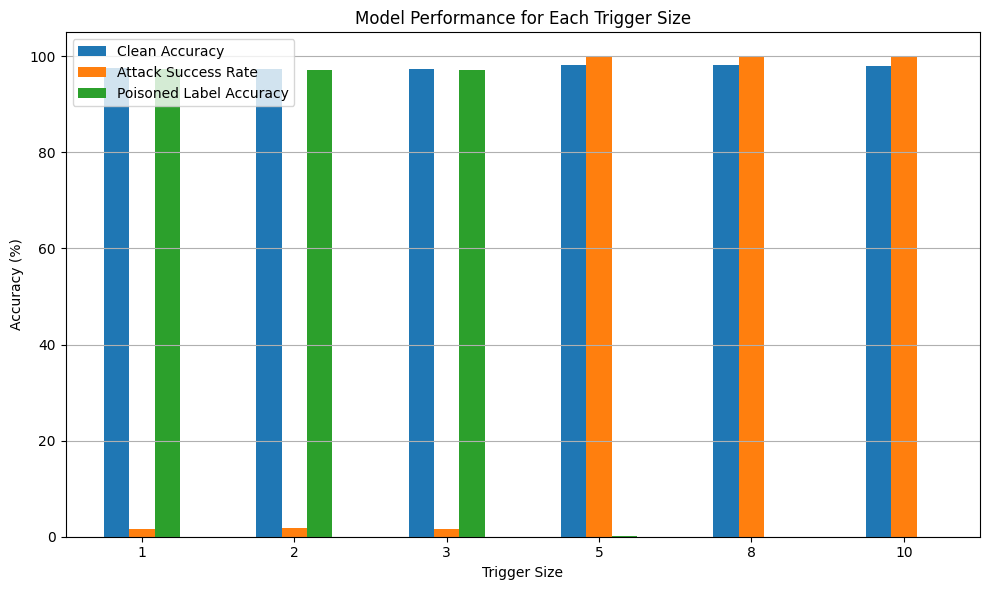

In [28]:
# ✅ Plot bar chart comparing final epoch results
df = pd.DataFrame(results_summary)
df.set_index("trigger_size", inplace=True)

df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance for Each Trigger Size")
plt.ylabel("Accuracy (%)")
plt.xlabel("Trigger Size")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


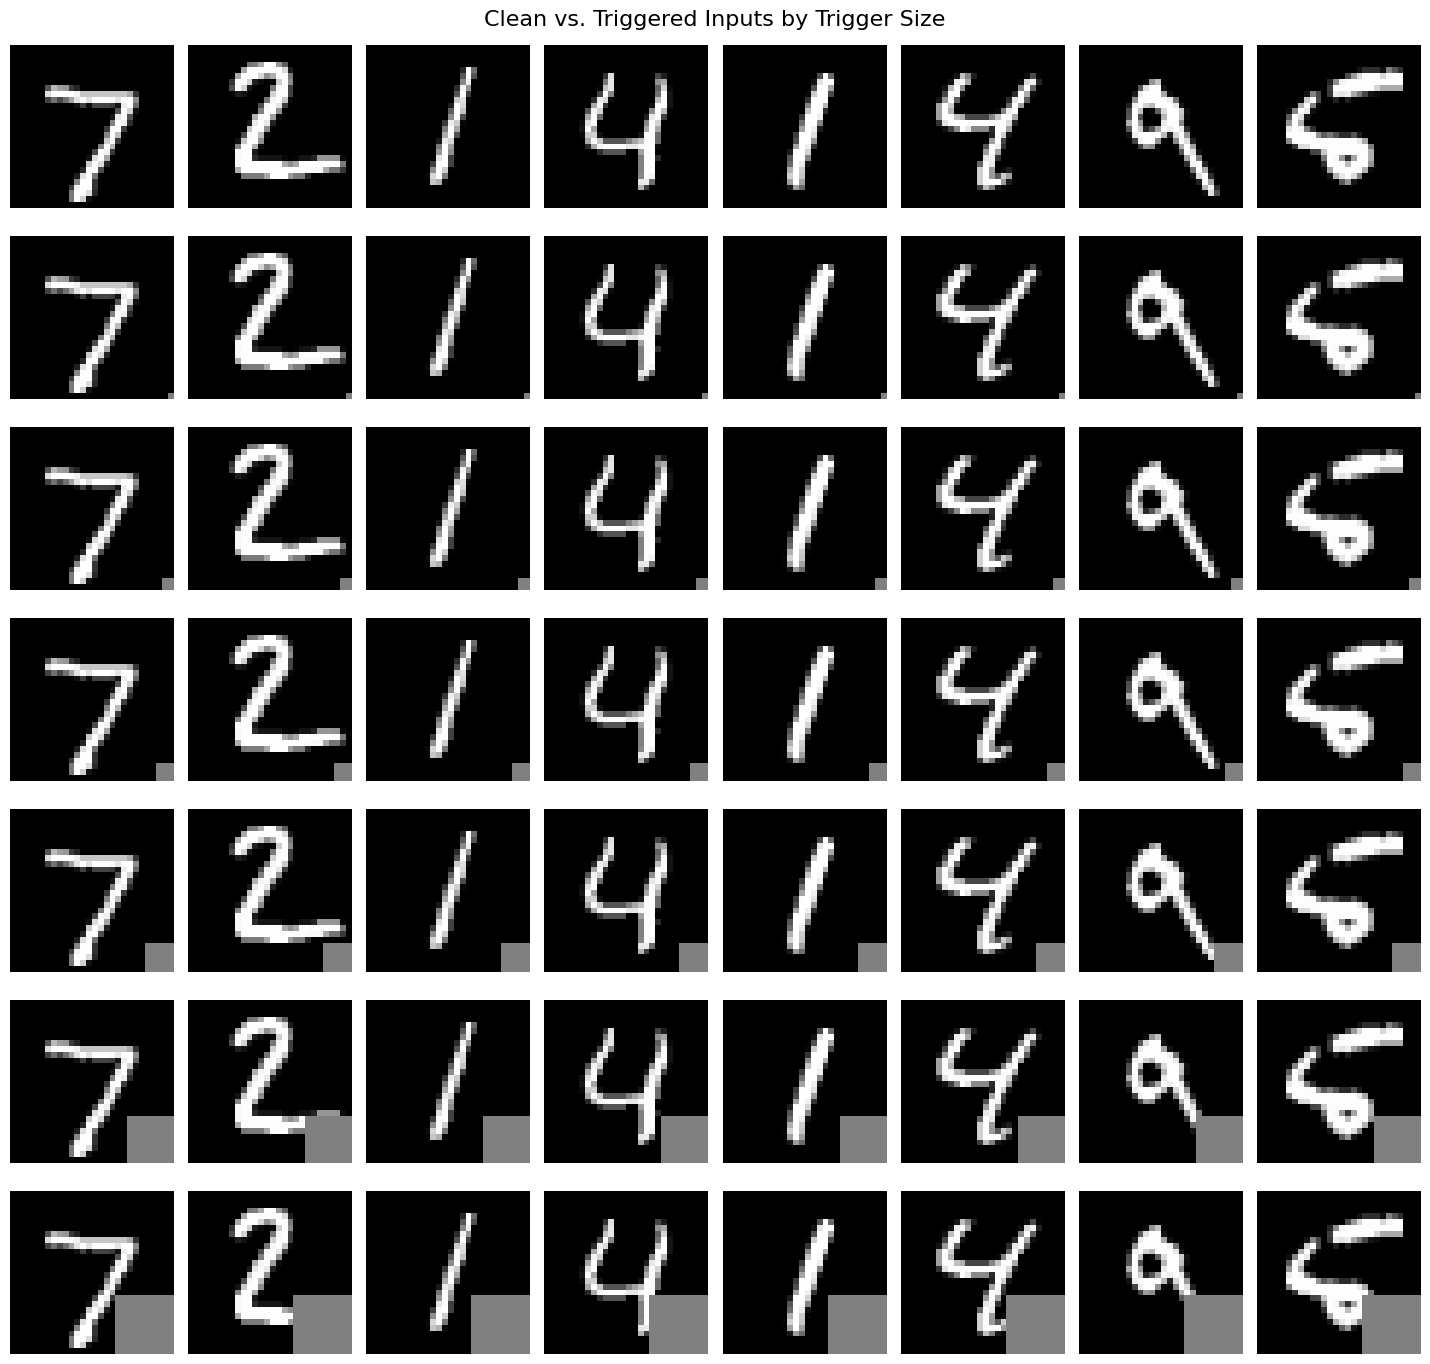

In [29]:


def visualize_trigger_comparison(test_loader, trigger_sizes=[1, 2, 3, 5, 8, 10], num_images=8, target_label=0):
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            idx = labels != target_label
            images, labels = images[idx], labels[idx]
            if images.size(0) < num_images:
                continue

            base_images = images[:num_images].clone()

            total_rows = 1 + len(trigger_sizes)  # 1 for clean row + N trigger sizes
            plt.figure(figsize=(num_images * 1.8, total_rows * 2))

            # Row 0: Clean images
            for i in range(num_images):
                plt.subplot(total_rows, num_images, i + 1)
                plt.imshow(base_images[i].cpu().squeeze(), cmap="gray")
                plt.axis("off")
                if i == 0:
                    plt.ylabel("Clean", fontsize=12)

            # Rows for each trigger size
            for row_idx, size in enumerate(trigger_sizes):
                triggered_imgs, _ = add_trigger(base_images.clone(), labels[:num_images].clone(), target_label=target_label,
                                                num=num_images, trigger_size=size)
                for i in range(num_images):
                    plt.subplot(total_rows, num_images, (row_idx + 1) * num_images + i + 1)
                    plt.imshow(triggered_imgs[i].cpu().squeeze(), cmap="gray")
                    plt.axis("off")
                    if i == 0:
                        plt.ylabel(f"Trigger {size}x{size}", fontsize=12)

            plt.suptitle("Clean vs. Triggered Inputs by Trigger Size", fontsize=16)
            plt.tight_layout()
            plt.show()
            break  # only visualize the first batch

visualize_trigger_comparison(test_loader, trigger_sizes=[1, 2, 3, 5, 8, 10], num_images=8, target_label=0)
